In [1]:
# two

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = 0.5,
        m_rate = 0.5,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.1,
        grow_factor = 0.1,
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 1000
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    

C:\Users\AI-lab\github_repo\neural-network\python\ga.py:203: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9629629629629629, Loss: 0.37705170666729965
Checkpoint 200, Accuracy: 0.9506172839506173, Loss: 0.3291926560578523
Checkpoint 300, Accuracy: 0.9506172839506173, Loss: 0.29736384639033564
Checkpoint 400, Accuracy: 0.9506172839506173, Loss: 0.2744091175220631
Checkpoint 500, Accuracy: 0.9629629629629629, Loss: 0.24728420045640734
Checkpoint 600, Accuracy: 0.9567901234567902, Loss: 0.22844358726784034
Checkpoint 700, Accuracy: 0.9567901234567902, Loss: 0.21055218025490088
Checkpoint 800, Accuracy: 0.9629629629629629, Loss: 0.19782089304040978
Checkpoint 900, Accuracy: 0.9567901234567902, Loss: 0.1875857777065701
Checkpoint 1000, Accuracy: 0.9629629629629629, Loss: 0.17210190384476273


In [10]:
train_acc = [ h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

In [11]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.95330334 0.02628225 0.02041439]
[1. 0. 0.] <-> [0.95846826 0.02770802 0.01382378]
[1. 0. 0.] <-> [0.9401158  0.01316053 0.04672362]
[1. 0. 0.] <-> [0.9555382  0.01339143 0.03107027]
[0. 0. 1.] <-> [0.00366003 0.03608252 0.9602574 ]
[1. 0. 0.] <-> [0.97676337 0.01197645 0.01126019]
[1. 0. 0.] <-> [0.9574196  0.01275408 0.02982637]
[1. 0. 0.] <-> [0.97446895 0.01329979 0.01223123]
[1. 0. 0.] <-> [0.9751463  0.01415661 0.0106971 ]
[1. 0. 0.] <-> [0.9356256  0.03899163 0.0253827 ]
[0. 1. 0.] <-> [0.06233305 0.92929393 0.00837302]
[1. 0. 0.] <-> [0.94016254 0.01126888 0.04856858]
[1. 0. 0.] <-> [0.9700828  0.0205159  0.00940129]
[0. 1. 0.] <-> [0.06249785 0.929113   0.00838925]
[1. 0. 0.] <-> [0.89635336 0.00936681 0.09427984]
[1. 0. 0.] <-> [0.9532703  0.03429687 0.01243285]
[1. 0. 0.] <-> [0.64551693 0.01574616 0.33873692]
[1. 0. 0.] <-> [0.97395575 0.01367438 0.01236989]
[1. 0. 0.] <-> [0.9670255  0.01399281 0.01898165]
[1. 0. 0.] <-> [0.9705959  0.01437491 0.01502913]


In [13]:
# Testing Performance

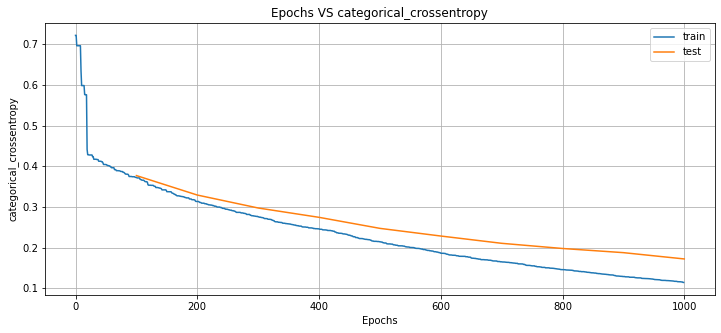

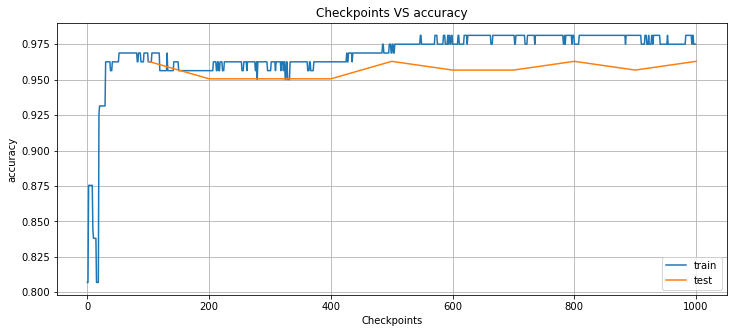

In [14]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [15]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9629629629629629, 'mean_square_error': 0.17759456212936856, 'categorical_crossentropy': 0.37705170666729965, 'precision': 0.9444444444444444, 'recall': 0.9444444444444444, 'f1': 0.9444444444444444, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 6, 'tn_hit': 26, 'fn_hit': 0}, 1: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 4}, 2: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 2}}, 'checkpoint': 100} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.15565056492150445, 'categorical_crossentropy': 0.3291926560578523, 'precision': 0.9259259259259259, 'recall': 0.9259259259259259, 'f1': 0.9259259259259259, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 8, 'tn_hit': 24, 'fn_hit': 0}, 1: {'tp_hit': 11, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 6}, 2: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.1415868132522953, 'categorical_crossentropy': 0.29736384639033564, 'precisi

In [16]:
print(model)

Layer 1
Neuron 0: weights:
[-2.3137474  2.77886    2.5778575 -0.6476738  2.5932493]
 bias: -1.5767602920532227

Neuron 1: weights:
[ 0.70902413 -2.3552184  -0.89104146  0.23352928 -0.43252194]
 bias: 1.458749532699585

Neuron 2: weights:
[-0.5984084   0.95122325  2.6232133  -1.2505903  -1.8094075 ]
 bias: 2.594257354736328

Neuron 3: weights:
[ 1.514795   -2.687678    0.54862463  0.9819324   0.10724245]
 bias: -1.8334943056106567

$
Layer 2
Neuron 0: weights:
[-1.8871939  0.473528   1.8141048 -2.8994875]
 bias: -2.339906930923462

Neuron 1: weights:
[ 2.2989268 -3.        -1.0099967 -3.       ]
 bias: -0.9982329607009888

Neuron 2: weights:
[ 0.9923135   0.00866543 -2.7958748   0.5290127 ]
 bias: -2.6171724796295166

$

